## Greek Restaurant's a-plenty
This Notebook will be used as a step-by-step to show how I have managed to work through this project

## Introduction

The purpose of this project is provide an identification for the closest rated restaurants to a user's location, by using location data from the Foursquare API and methods of clustering to reach my final output. 

## Data

As a core foundation, lets begin by looking at London using the folium library.

We will then proceed to fetch the relevant data we are after from Zomato based on London Greek restaurants, about 15 miles from the long & lat cordinates for London in all directions.

## Web Scrap from Wikipedia on Areas in London

In [217]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

from geopy.geocoders import Nominatim

address='Tower Hamlets, London, Greater London' #test on one area first to ensure it works.
geolocator = Nominatim(user_agent="Your_Name")
location = geolocator.geocode(address)
print(location.address)
print((location.latitude, location.longitude))

St. Katharine's Way, St Katharine's Way, St. George in the East, London Borough of Tower Hamlets, London, Greater London, England, EW1, United Kingdom
(51.5057967, -0.0705771)


In [218]:
url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'

data = requests.get(url).text

soup = BeautifulSoup(data,'html.parser')

wiki_table = soup.find('table',class_='wikitable')

df = pd.read_html(str(wiki_table))[0]

df_new = df[['Borough']]

a = df_new['Borough'].str.split('[')

b = a[0:32]

dataframe = []
for i in range(len(b)):
    dataframe.append(b[i][0])

list_of_towns = pd.DataFrame(dataframe, columns = ['Borough'])
list_of_towns

,Borough
0,Barking and Dagenham
1,Barnet
2,Bexley
3,Brent
4,Bromley
5,Camden
6,Croydon
7,Ealing
8,Enfield
9,Greenwich


In [219]:
Boroughs = [] #data wrangling to get this in the shape we want.

for i in list_of_towns['Borough']:
    address=i+', '+'London, Greater London'
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    name = i
    lat = location.latitude
    long = location.longitude
    Boroughs.append([name, lat, long])

Boroughs = pd.DataFrame(Boroughs, columns=['name','lat','long'])

Boroughs

,name,lat,long
0,Barking and Dagenham,51.554117,0.150504
1,Barnet,51.653090,-0.200226
2,Bexley,51.441679,0.150488
3,Brent,51.563996,-0.275906
4,Bromley,51.366857,0.061709
5,Camden,51.542305,-0.139560
6,Croydon,51.371305,-0.101957
7,Ealing,51.512655,-0.305195
8,Enfield,51.652085,-0.081018
9,Greenwich,51.482084,-0.004542


## Lets find the cordinates for London

A simple Google search will suffice

In [220]:
LDN_LATITUDE = '51.509865'
LDN_LONGITUDE = '-0.118092'
print('London cordinates are {}, {}.'.format(LDN_LATITUDE, LDN_LONGITUDE))

London cordinates are 51.509865, -0.118092.


Next we can show a basic map of London city. First introduction to folium is pretty straightforward to use

In [223]:
import folium 

ldn = folium.Map(location = [LDN_LATITUDE, LDN_LONGITUDE], zoom_start = 13)
folium.TileLayer('cartodbdark_matter').add_to(ldn)
folium.Marker([LDN_LATITUDE, LDN_LONGITUDE]).add_to(ldn)
#ldn.save("maps/ldn.html")
ldn

## Work out distance between Boroughs and London location

This conducted using the Haversine formula. It is required so that we are able to eventually spot which boroughs are the closest to the centre and will no doubt form part of our analysis. 

In [224]:
import geopy.distance
from geopy import Point

site_coords = (51.509865, -0.118092)

Boroughs['Ldn_lat'] = float(LDN_LATITUDE)
Boroughs['Ldn_long'] = float(LDN_LONGITUDE)


distances = []

for index, row in Boroughs.iterrows():
    if index > 0:
        name = row[0]
        x = geopy.distance.distance(site_coords, (row[1],row[2])).km
        distances.append([name, x])

distances = pd.DataFrame(distances, columns=['name','distance_km'])

boroughs_distances = pd.merge(left=Boroughs, right=distances, left_on='name', right_on='name')

boroughs_distances

,name,lat,long,Ldn_lat,Ldn_long,distance_km
0,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623
1,Bexley,51.441679,0.150488,51.509865,-0.118092,20.143313
2,Brent,51.563996,-0.275906,51.509865,-0.118092,12.496790
3,Bromley,51.366857,0.061709,51.509865,-0.118092,20.234981
4,Camden,51.542305,-0.139560,51.509865,-0.118092,3.904606
5,Croydon,51.371305,-0.101957,51.509865,-0.118092,15.456508
6,Ealing,51.512655,-0.305195,51.509865,-0.118092,12.993047
7,Enfield,51.652085,-0.081018,51.509865,-0.118092,16.030654
8,Greenwich,51.482084,-0.004542,51.509865,-0.118092,8.469772
9,Hackney,51.543240,-0.049362,51.509865,-0.118092,6.044831


## Foursquare API

We connect to Foursquare API and begin our search of restaurants

In [225]:
FOURSQUARE_CLIENT_ID = 'client id'
FOURSQUARE_CLIENT_SECRET = 'client secret'
ACCESS_TOKEN = 'access token' 
RADIUS = 24000
NO_OF_VENUES = 100
VERSION = '20180604'
CATEGORYID = '4bf58dd8d48988d10e941735'
LIMIT = 100
offset = 30
search_query = 'Greek Restaurant'

## Import the libraries we will use

In [226]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

## Create functions that will allow us to work with the JSON data we pull from Foursquare

In [227]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=5000, limit=150):
    version = '20180604'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   item['venue']['categories'],
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   (item['venue']['location']),
                   item['venue']['location']['distance'],
                   lat,
                   lon) for item in results]        
    except:
        venues = []
    return venues

def get_restaurants(lats, lons):
    location_restaurants = []

    #print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(boroughs_distances['lat'], boroughs_distances['long']):
        venues = get_venues_near_location(lat, lon, CATEGORYID, FOURSQUARE_CLIENT_ID, FOURSQUARE_CLIENT_SECRET, radius=5000, limit=150)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_lat = venue[6]
            venue_lon = venue[7]
            restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_distance, venue_lat, venue_lon)
            location_restaurants.append(restaurant)
            #print(' .', end='')
    #print(' done.')
    return location_restaurants

## Inspect the data that we are getting from Foursquare and see how it looks in a dataframe

In [11]:
foursquare_venues = pd.DataFrame(columns=['id','name','categories','address','lat','lng'])

venues = result['response']['groups'][0]['items']
venue = json_normalize(venues)

#Filter columns

Filtered_columns = ['venue.id','venue.name','venue.categories','venue.location.address','venue.location.lat','venue.location.lng']

venues = venue.loc[:, Filtered_columns]

venues['venue.categories'] = venues.apply(get_category_type, axis=1)

venues
#Deal with column name cleanse

venues.columns = [col.split('.')[-1] for col in venues.columns]

foursquare_api = pd.concat([foursquare_venues, venues], axis=0, sort=False)

foursquare_api

<ipython-input-11-77ea9aa3679b>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  venue = json_normalize(venues)


,id,name,categories,address,lat,lng
0,5ac4c2913d47911cdd1b7e52,GReat,Greek Restaurant,98 Farringdon Rd,51.524777,-0.110336
1,53ad4446498e59958f1d8678,OPSO,Greek Restaurant,10 Paddington St,51.520784,-0.152891
2,4bb7e1f2b35776b07c57c801,Halepi,Greek Restaurant,18 Leinster Terr,51.511356,-0.183005
3,55df738f498e7d1805fafb9d,Milos,Greek Restaurant,1-3 Regent St,51.508117,-0.133341
4,4fb5902e754addc067345b2a,Mazi,Greek Restaurant,12-14 Hillgate St,51.508191,-0.197615
...,...,...,...,...,...,...
95,4bf6e0754a67c928ac9622cf,Atlantis Greek Restaurant,Greek Restaurant,86 Pitshanger Ln.,51.526121,-0.314210
96,56d440c4cd10a993880ce733,YEERO @ EC1,Greek Restaurant,1 St John Street,51.519735,-0.101987
97,4c891aa097828cfaea7ca1aa,Blueberries,Greek Restaurant,294 East Barnet Road,51.643004,-0.163926
98,4c46e198417b20a15bbedba9,Aroma Patisserie,Greek Restaurant,424-426 Green Lanes,51.622335,-0.105142


## Using the data we pulled from Foursquare on restaurant closest to the boroughs, we can hook this onto our main data frame on boroughs to see the number of restaurants within a local radius

import json 

output = get_restaurants(boroughs_distances['lat'], boroughs_distances['long'])

Filtered_columns_json = ['id','restaurant_name','lat_restaurant','lng_restaurant','distance','lat','lng']

restaurant_locations = pd.DataFrame(output, columns=Filtered_columns_json)

restaurant_locations

In [229]:
merged_df = pd.merge(boroughs_distances, restaurant_locations, on='lat',how='left')

merged_df.sort_values(by=['name'])

,name,lat,long,Ldn_lat,Ldn_long,distance_km,id,restaurant_name,lat_restaurant,lng_restaurant,distance,lng
0,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,4de9457fb0fbcb7c9ad93459,Deserie,51.650814,-0.149359,3522.0,-0.200226
1,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,4dab68456e81162ae7ecc86f,B-B-Q Grill,51.630079,-0.174623,3112.0,-0.200226
2,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,4bb105c0f964a520a5733ce3,Blue Olive,51.648707,-0.147723,3658.0,-0.200226
3,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,4c891aa097828cfaea7ca1aa,Blueberries,51.643004,-0.163926,2747.0,-0.200226
4,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,4d41c751cb84b60cb85c92ab,Pan-Elis,51.647600,-0.133411,4655.0,-0.200226
...,...,...,...,...,...,...,...,...,...,...,...,...
650,Westminster,51.500444,-0.126540,51.509865,-0.118092,1.201128,4de28593e4cd056f7445be2b,Santorini Taverna,51.512682,-0.188235,4486.0,-0.126540
649,Westminster,51.500444,-0.126540,51.509865,-0.118092,1.201128,5555d73f498eba1d92b0bd0a,Briki,51.526369,-0.108318,3149.0,-0.126540
648,Westminster,51.500444,-0.126540,51.509865,-0.118092,1.201128,4c357e4766e40f47a54ecb8b,Konaki Greek Restaurant,51.517374,-0.126495,1884.0,-0.126540
655,Westminster,51.500444,-0.126540,51.509865,-0.118092,1.201128,554d164a498e1f4802f57a0e,Hungry Donkey,51.516875,-0.074113,4066.0,-0.126540


## Add in additional columns to accumulate total restaurants in that area

In [230]:
merged_dfe = pd.merge(boroughs_distances, restaurant_locations, on='lat',how='left')
merged_dfe = merged_dfe[['name','lat','long','Ldn_lat','Ldn_long','distance_km','id','distance']]

merged_dfe['total_restaraunts_in_area'] = merged_dfe.groupby('name')['id'].transform('count')
merged_dfe['nearest_greek_restaraunts_in_area'] = merged_dfe.groupby('name')['distance'].transform('min')

merged_dfe = merged_dfe[['name','lat','long','Ldn_lat','Ldn_long','distance_km','total_restaraunts_in_area','nearest_greek_restaraunts_in_area']]

merged_dfe.drop_duplicates().reset_index(drop=True)

,name,lat,long,Ldn_lat,Ldn_long,distance_km,total_restaraunts_in_area,nearest_greek_restaraunts_in_area
0,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,6,2747.0
1,Bexley,51.441679,0.150488,51.509865,-0.118092,20.143313,4,32.0
2,Brent,51.563996,-0.275906,51.509865,-0.118092,12.496790,2,1523.0
3,Bromley,51.366857,0.061709,51.509865,-0.118092,20.234981,0,NaN
4,Camden,51.542305,-0.139560,51.509865,-0.118092,3.904606,68,475.0
5,Croydon,51.371305,-0.101957,51.509865,-0.118092,15.456508,2,673.0
6,Ealing,51.512655,-0.305195,51.509865,-0.118092,12.993047,6,458.0
7,Enfield,51.652085,-0.081018,51.509865,-0.118092,16.030654,11,3104.0
8,Greenwich,51.482084,-0.004542,51.509865,-0.118092,8.469772,6,1955.0
9,Hackney,51.543240,-0.049362,51.509865,-0.118092,6.044831,36,1182.0


## EDA Analysis to see how many restaurants there are in an area etc

In [231]:
import numpy as np

print('Total Number of Restaurants:{}'.format(len(result['response']['groups'][0]['items'])))
print('Average number of restaurants in neighborhood:', round(merged_dfe['total_restaraunts_in_area'].mean()))

Total Number of Restaurants:100
Average number of restaurants in neighborhood: 52


In [233]:
ldn_rest_map = folium.Map(location = [LDN_LATITUDE, LDN_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude in zip(foursquare_api['name'], foursquare_api['address'], foursquare_api['lat'], foursquare_api['lng']):
    label = '{}\n{}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.TileLayer('cartodbdark_matter').add_to(ldn_rest_map)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(ldn_rest_map)  

ldn_rest_map

## Methodology 
In this project we will direct our efforts on detecting areas of London that have low restaurant density. It is important to group up our boroughs and roll up the restaurants into those respective boroughs. This allows us to get an overview of the picture and effectively plug this into our machine learning algorithm.

In [234]:
merged_dfe.drop_duplicates().reset_index(drop=True)

,name,lat,long,Ldn_lat,Ldn_long,distance_km,total_restaraunts_in_area,nearest_greek_restaraunts_in_area
0,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,6,2747.0
1,Bexley,51.441679,0.150488,51.509865,-0.118092,20.143313,4,32.0
2,Brent,51.563996,-0.275906,51.509865,-0.118092,12.496790,2,1523.0
3,Bromley,51.366857,0.061709,51.509865,-0.118092,20.234981,0,NaN
4,Camden,51.542305,-0.139560,51.509865,-0.118092,3.904606,68,475.0
5,Croydon,51.371305,-0.101957,51.509865,-0.118092,15.456508,2,673.0
6,Ealing,51.512655,-0.305195,51.509865,-0.118092,12.993047,6,458.0
7,Enfield,51.652085,-0.081018,51.509865,-0.118092,16.030654,11,3104.0
8,Greenwich,51.482084,-0.004542,51.509865,-0.118092,8.469772,6,1955.0
9,Hackney,51.543240,-0.049362,51.509865,-0.118092,6.044831,36,1182.0


In [235]:
print('Average distance (metres) to closest Greek restaurant from each area center:', round(merged_dfe['nearest_greek_restaraunts_in_area'].mean(),2))

Average distance (metres) to closest Greek restaurant from each area center: 879.2


In [236]:
import requests
import numpy as np

geo_json = 'https://raw.githubusercontent.com/ft-interactive/geo-data/master/uk/medium-local-authorities.topojson'

london_borough_file = requests.get(geo_json).json()

def boroughs_style(feature):
    return { 'color': 'white', 'fill': False }

## Plot the restaurants on a map so we can visually inspect

In [237]:
from folium import plugins
from folium.plugins import HeatMap

map_london = folium.Map(location=[LDN_LATITUDE, LDN_LONGITUDE], zoom_start=13)
folium.TileLayer('cartodbdark_matter').add_to(map_london) #cartodbpositron cartodbdark_matter
for name, address, latitude, longitude in zip(foursquare_api['name'], foursquare_api['address'], foursquare_api['lat'], foursquare_api['lng']):
    folium.CircleMarker([latitude, longitude]).add_to(map_london)
folium.Marker([LDN_LATITUDE, LDN_LONGITUDE]).add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=1000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=2000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=3000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=6000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=9000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=12000, fill=False, color='white').add_to(map_london)
folium.Circle([LDN_LATITUDE, LDN_LONGITUDE], radius=15000, fill=False, color='white').add_to(map_london)
folium.GeoJson(london_borough_file, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

## Create model with current set of 3 clusters before we find the optimal value

In [238]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = merged_dfe[['total_restaraunts_in_area']]
model = kmeans.fit(X)
model.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Text(0, 0.5, 'Error')

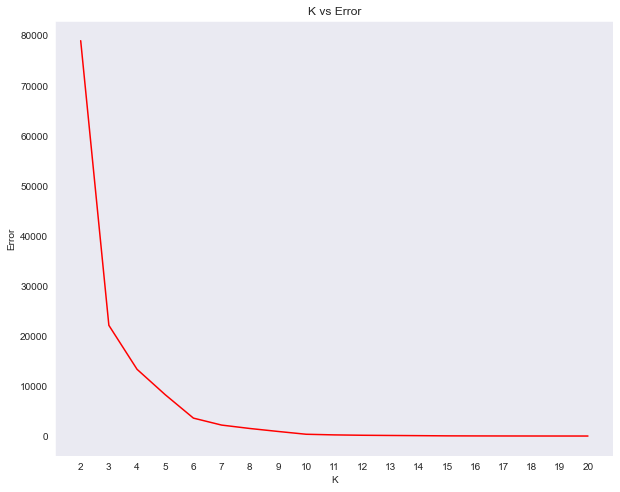

In [246]:
import seaborn as sns

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

scores = [get_inertia(x) for x in range(2, 21)]

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
sns.set_style("ticks")
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [247]:
kclusters = 6

ldn_grouped_clustering = X

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ldn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Hook cluster labels onto main dataframe

In [252]:
merged_dfe['Clusters'] = kmeans.labels_

final = merged_dfe.drop_duplicates().reset_index(drop=True)

final

,name,lat,long,Ldn_lat,Ldn_long,distance_km,total_restaraunts_in_area,nearest_greek_restaraunts_in_area,Clusters
0,Barnet,51.653090,-0.200226,51.509865,-0.118092,16.921623,6,2747.0,2
1,Bexley,51.441679,0.150488,51.509865,-0.118092,20.143313,4,32.0,2
2,Brent,51.563996,-0.275906,51.509865,-0.118092,12.496790,2,1523.0,2
3,Bromley,51.366857,0.061709,51.509865,-0.118092,20.234981,0,NaN,2
4,Camden,51.542305,-0.139560,51.509865,-0.118092,3.904606,68,475.0,3
5,Croydon,51.371305,-0.101957,51.509865,-0.118092,15.456508,2,673.0,2
6,Ealing,51.512655,-0.305195,51.509865,-0.118092,12.993047,6,458.0,2
7,Enfield,51.652085,-0.081018,51.509865,-0.118092,16.030654,11,3104.0,2
8,Greenwich,51.482084,-0.004542,51.509865,-0.118092,8.469772,6,1955.0,2
9,Hackney,51.543240,-0.049362,51.509865,-0.118092,6.044831,36,1182.0,5


## Plot our clusters onto a map

In [277]:
# create map
map_clusters = folium.Map(location=[LDN_LATITUDE, LDN_LONGITUDE], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_dfe['lat'], merged_dfe['long'], merged_dfe['name'], merged_dfe['Clusters']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.TileLayer('cartodbdark_matter').add_to(map_clusters) #cartodbpositron cartodbdark_matter
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       


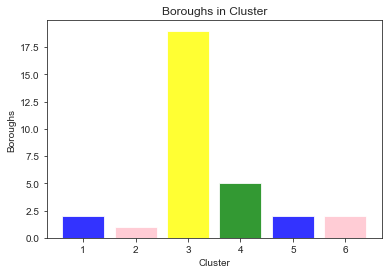

In [254]:
objects = (1,2,3,4,5,6)
y_pos = np.arange(len(objects))
performance = final['Clusters'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Clusters'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['blue', 'pink','yellow', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Boroughs')
plt.xlabel('Cluster')
plt.title('Boroughs in Cluster')

plt.show()

In [259]:
final['Clusters'].value_counts().sort_values()

1     1
0     2
4     2
5     2
3     5
2    19
Name: Clusters, dtype: int64

In [276]:
filtered_list = final[['name','lat','long','distance_km','total_restaraunts_in_area','Clusters']].sort_values(['total_restaraunts_in_area'], ascending=False)

top_3 = filtered_list[filtered_list['Clusters']==2].sort_values(['distance_km'], ascending=True)

top_3

,name,lat,long,distance_km,total_restaraunts_in_area,Clusters
8,Greenwich,51.482084,-0.004542,8.469772,6,2
28,Waltham Forest,51.563187,-0.028841,8.575778,9,2
20,Lewisham,51.462432,-0.010133,9.169732,8,2
22,Newham,51.530000,0.029318,10.474112,9,2
21,Merton,51.410870,-0.188097,12.040696,2,2
2,Brent,51.563996,-0.275906,12.496790,2,2
6,Ealing,51.512655,-0.305195,12.993047,6,2
23,Redbridge,51.576320,0.045410,13.539910,5,2
24,Richmond upon Thames,51.440553,-0.307639,15.261066,5,2
5,Croydon,51.371305,-0.101957,15.456508,2,2


In [274]:
recommendation = folium.Map(location=[LDN_LATITUDE, LDN_LONGITUDE], zoom_start=13)

for lat, lon, poi, cluster in zip(top_3['lat'], top_3['long'], top_3['name'], top_3['Clusters']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.TileLayer('cartodbdark_matter').add_to(recommendation) #cartodbpositron cartodbdark_matter
    folium.Circle([lat, lon], radius=1000, fill=False, color='white').add_to(recommendation)
    folium.Circle([lat, lon], radius=2000, fill=False, color='white').add_to(recommendation)
    folium.Circle([lat, lon], radius=3000, fill=False, color='white').add_to(recommendation)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(recommendation)

recommendation